In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)

In [2]:
path ='https://github.com/DS-100/textbook/raw/master/content/'
ice = pd.read_csv(path + 'ch/15/icecream.csv')
ice

,sweetness,overall
0,4.1,3.9
1,6.9,5.4
2,8.3,5.8
...,...,...
6,11.0,5.9
7,11.7,5.5
8,11.9,5.4


In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
trans_ten = PolynomialFeatures(degree=10)
X_ten = trans_ten.fit_transform(ice[['sweetness']])
y = ice['overall']
clf_ten = LinearRegression(fit_intercept=False).fit(X_ten, y)

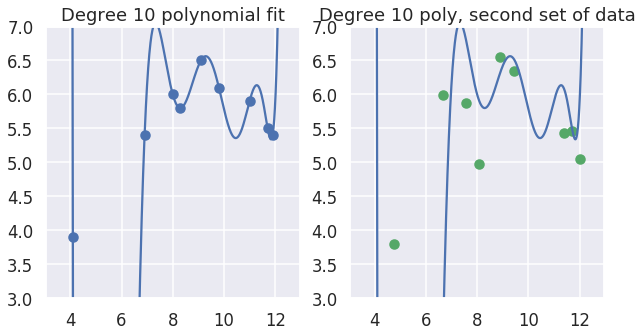

In [4]:
np.random.seed(1)
x_devs = np.random.normal(scale=0.4, size=len(ice))
y_devs = np.random.normal(scale=0.4, size=len(ice))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(ice['sweetness'], ice['overall'])
xs = np.linspace(3.5, 12.5, 1000).reshape(-1, 1)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.title('Degree 10 polynomial fit')
plt.ylim(3, 7);

plt.subplot(122)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.scatter(ice['sweetness'] + x_devs,
            ice['overall'] + y_devs,
            c='g')
plt.title('Degree 10 poly, second set of data')
plt.ylim(3, 7);

In [5]:
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(ice[['sweetness']])

clf = LinearRegression(fit_intercept=False).fit(X, ice[['overall']])
xs = np.linspace(3.5, 12.5, 300).reshape(-1, 1)
rating_pred = clf.predict(transformer.transform(xs))

temp = pd.DataFrame(xs, columns = ['sweetness'])
temp['overall'] = rating_pred

np.random.seed(42)
x_devs = np.random.normal(scale=0.2, size=len(temp))
y_devs = np.random.normal(scale=0.2, size=len(temp))
temp['sweetness'] = np.round(temp['sweetness'] + x_devs, decimals=2)
temp['overall'] = np.round(temp['overall'] + y_devs, decimals=2)

ice = pd.concat([temp, ice])
ice

,sweetness,overall
0,3.60,3.09
1,3.50,3.17
2,3.69,3.46
...,...,...
6,11.00,5.90
7,11.70,5.50
8,11.90,5.40


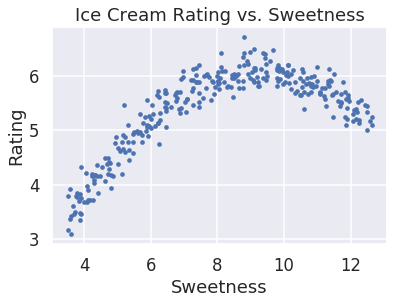

In [6]:
plt.scatter(ice['sweetness'], ice['overall'], s=10)
plt.title('Ice Cream Rating vs. Sweetness')
plt.xlabel('Sweetness')
plt.ylabel('Rating');

In [7]:
from sklearn.model_selection import train_test_split
test_size = 92
X_train, X_test, y_train, y_test = train_test_split(ice[['sweetness']],
             ice['overall'], test_size=test_size, random_state=0)
print(f'  Training set size: {len(X_train)}')
print(f'      Test set size: {len(X_test)}')

  Training set size: 217
      Test set size: 92


In [8]:
# First, we add polynomial features to X_train
transformers = [PolynomialFeatures(degree=deg)
                for deg in range(1, 11)]
X_train_polys = [transformer.fit_transform(X_train)
                 for transformer in transformers]
# Display the X_train with degree 5 polynomial features
X_train_polys[4]

array([[     1.  ,      8.8 ,     77.44,    681.47,   5996.95,  52773.19],
       [     1.  ,     10.74,    115.35,   1238.83,  13305.07, 142896.44],
       [     1.  ,      9.98,     99.6 ,    994.01,   9920.24,  99003.99],
       ...,
       [     1.  ,      6.79,     46.1 ,    313.05,   2125.59,  14432.74],
       [     1.  ,      5.13,     26.32,    135.01,    692.58,   3552.93],
       [     1.  ,      8.66,     75.  ,    649.46,   5624.34,  48706.78]])

In [0]:
from sklearn.model_selection import KFold
def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        # Fit the model on the training split
        model.fit(split_X_train,split_Y_train)
        # Compute the RMSE on the validation split
        error = mse_cost(split_Y_valid,model.predict(split_X_valid))
        validation_errors.append(error)
    #average validation errors
    return np.mean(validation_errors)

In [0]:
# We train a linear regression classifier for each featurized dataset and perform cross-validation
# We set fit_intercept=False for our linear regression classifier since 
# the PolynomialFeatures transformer adds the bias column for us.
cross_validation_errors = [compute_CV_error
                  (LinearRegression(fit_intercept=False),
 X_train_poly, y_train) for X_train_poly in X_train_polys]

In [11]:
cv_df = pd.DataFrame({'Validation Error':
 cross_validation_errors}, index=range(1, 11))
cv_df.index.name = 'Degree'
display(cv_df)

,Validation Error
Degree,
1,0.32
2,0.05
3,0.05
...,...
8,0.05
9,0.05
10,0.05


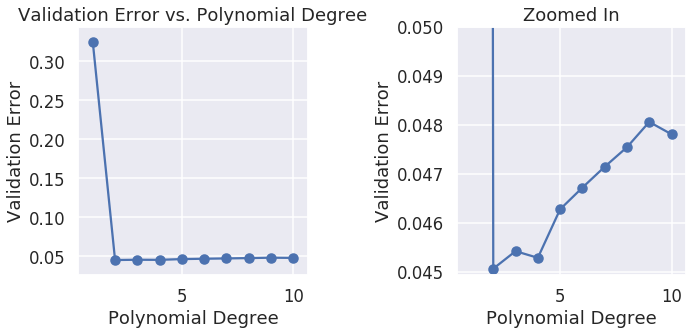

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.title('Validation Error vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error');

plt.subplot(122)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.ylim(0.044925, 0.05)
plt.title('Zoomed In')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error')

plt.tight_layout();

In [13]:
best_trans = transformers[1]
best_model = LinearRegression(fit_intercept=False).fit(X_train_polys[1],
                                                       y_train)
training_error = mse_cost(best_model.predict(X_train_polys[1]), y_train)
validation_error = cross_validation_errors[1]
test_error = mse_cost(best_model.predict(best_trans.transform(X_test)),
                                                          y_test)
print('Degree 2 polynomial')
print(f'  Training error: {training_error:0.5f}')
print(f'Validation error: {validation_error:0.5f}')
print(f'      Test error: {test_error:0.5f}')

Degree 2 polynomial
  Training error: 0.04409
Validation error: 0.04506
      Test error: 0.04698
